[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neo4j-field/call-transcripts-automation/blob/main/students/1_IngestTranscripts.ipynb)


# Ingesting Transcripts Overview

This is a [Python](https://www.python.org/) project for constructing a business-process aware knowledge graph for customer service automation and acceleration.

This notebook will use an 'agentic' approach to ingest customer service call transcripts (calls, messages, customer or representative), linking all of the entities appropriately, and lastly, creating vector embeddings of the comments.

All of the entities (Customer, Representative, Call, Comments), their cooresponding relationships, and the vector embeddings are stored within Neo4j.

**Update Student's environment code (received via email)**

In [ ]:
# The student's environment file (aura.env) will be downloaded into the notebook's
# files after executing the 'Setup' section.
STUDENT_ENV_CODE="817e"

# What we're ingesting


In [ ]:
from IPython.display import display, JSON
import requests

file_uri = "https://storage.googleapis.com/neo4j-nodes-network/transcripts.json"

data = requests.get(file_uri).json()

display(JSON(data[:2]))

# Setup

In [ ]:
%%capture
!pip --quiet install python-dotenv neo4j graphdatascience
!pip --quiet install langchain_neo4j langchain_openai langgraph

In [ ]:
import pandas as pd
import os

## Dotenv configuration

In [ ]:
# Download env file from S3
import requests

# GCS URL
GCS_FILE_URL = "https://storage.googleapis.com/neo4j-nodes-network/students/"+STUDENT_ENV_CODE+"/aura.txt"

# Local filename to save
LOCAL_ENV_FILE = "aura.env"

# Fetch the file and write it locally
response = requests.get(GCS_FILE_URL)
if response.status_code == 200:
    with open(LOCAL_ENV_FILE, "wb") as f:
        f.write(response.content)
    print(f"✅ Environment file downloaded and saved as {LOCAL_ENV_FILE}")
else:
    raise Exception(f"❌ Failed to fetch the .env file: {response.status_code}")

In [ ]:
# NOTE: Upload files (.env)!!!!
# You can skip this cell if not using a ws.env file - alternative to above
from dotenv import load_dotenv
import os

if os.path.exists(LOCAL_ENV_FILE):
     load_dotenv(LOCAL_ENV_FILE, override=True)

     # Neo4j
     NEO4J_URI = os.getenv('NEO4J_URI')
     NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
     NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')

     # AI
     LLM = 'gpt-4o'
     AZURE_OPENAI_API_KEY = os.getenv('AZURE_OPENAI_API_KEY')

print(f"OPENAI_KEY: {AZURE_OPENAI_API_KEY}")

## Connecting to Neo4j

Provide your Neo4j credentials. We need the DB conection URL, the username (probably neo4j), and your password.

If using an env file under the notebook's files folder, reference the:
- URI
- username
- password

Log into your Neo4j instance using https://browser.neo4j.io/.

In [ ]:
# # username is neo4j by default
# NEO4J_USERNAME = 'neo4j'

# # You will need to change these to match your credentials
# NEO4J_URI = 'neo4j+s://a51c4bb3.databases.neo4j.io'
# NEO4J_PASSWORD = 'R50r64jHpBzFgxZS6tttK7MXwO5agK6syL-Pznw5m_Y'

In [ ]:
from neo4j import GraphDatabase

# You can skip this cell if not using a ws.env file - alternative to above
# Get credentials from .env file
NEO4J_URI = os.getenv('NEO4J_URI')
NEO4J_USERNAME = os.getenv('NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('NEO4J_PASSWORD')

# with GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD)) as kg:
#     kg.verify_connectivity()

kg = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))

In [ ]:
# from graphdatascience import GraphDataScience

# gds = GraphDataScience(
#     NEO4J_URI,
#     auth=(NEO4J_USERNAME, NEO4J_PASSWORD),
#     aura_ds=False
# )
# gds.set_database('neo4j')

## Test connectivity

In [ ]:
# total node counts
res = kg.execute_query('''
    CALL apoc.meta.stats()
    YIELD labels
    UNWIND keys(labels) AS nodeLabel
    RETURN nodeLabel, labels[nodeLabel] AS nodeCount
    ORDER BY nodeCount DESC
''')

# print(res)
# for d in res.records:
#     print(d.data())

df = pd.DataFrame([{'nodeLabel': d['nodeLabel'],
               'nodeCount':d['nodeCount']} for d in res.records])
df[:]

# Variables and Utility functions

In [ ]:
from langchain_openai import OpenAIEmbeddings, AzureOpenAIEmbeddings

DEFAULT_EMBEDDING_MODEL = "text-embedding-3-small"
COMMENT_VECTOR_INDEX_NAME = "commentEmbeddings"
ENTITY_VECTOR_INDEX_NAME = "entityEmbeddings"
OBSERVATION_EMBEDDING_INDEX_NAME = "observationEmbeddings"
PROCESS_ELEMENT_EMBEDDING_INDEX_NAME = "processElementEmbeddings"
VECTOR_INDEX_DIM = 128
VECTOR_EQUIVALENCE_THRESHOLD = 0.9
DEFAULT_k = 7

# embedder = OpenAIEmbeddings(model=DEFAULT_EMBEDDING_MODEL, dimensions=VECTOR_INDEX_DIM)

embedder = AzureOpenAIEmbeddings(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    model=DEFAULT_EMBEDDING_MODEL,
    openai_api_version="2025-01-01-preview",
    dimensions=VECTOR_INDEX_DIM
)

## Create Graph and Vector embeddings stores

In [ ]:
from langchain_neo4j import Neo4jVector, Neo4jGraph

def create_graph_store():
    graph_db = Neo4jGraph(url=os.getenv("NEO4J_URI"), username=os.getenv("NEO4J_USERNAME"), password=os.getenv("NEO4J_PASSWORD"))
    graph_db.query("CREATE CONSTRAINT commentId IF NOT EXISTS FOR (c:Comment) REQUIRE c.id IS NODE KEY")
    graph_db.query("CREATE CONSTRAINT callId IF NOT EXISTS FOR (c:Call) REQUIRE c.id IS NODE KEY")
    graph_db.query("CREATE CONSTRAINT entityName IF NOT EXISTS FOR (e:Entity) REQUIRE e.name IS NODE KEY")
    graph_db.query("CREATE CONSTRAINT customerId IF NOT EXISTS FOR (c:Customer) REQUIRE c.id IS NODE KEY")
    graph_db.query("CREATE CONSTRAINT representativeId IF NOT EXISTS FOR (r:Representative) REQUIRE r.id IS NODE KEY")
    graph_db.query("CREATE CONSTRAINT observationId IF NOT EXISTS FOR (o:Observation) REQUIRE o.id IS NODE KEY")
    graph_db.query("CREATE CONSTRAINT processElementId IF NOT EXISTS FOR (p:ProcessElement) REQUIRE p.id IS NODE KEY")
    return graph_db

In [ ]:
# We're using multiple vector indexes because we want to query for chunks and entities separately
def create_vector_stores():
    comment_vector_db = Neo4jVector(
        embedder,
        url=os.getenv("NEO4J_URI"),
        username=os.getenv("NEO4J_USERNAME"),
        password=os.getenv("NEO4J_PASSWORD"),
        index_name=COMMENT_VECTOR_INDEX_NAME,
        embedding_dimension=VECTOR_INDEX_DIM,
        node_label="Comment"
    )
    comment_vector_db.create_new_index()
    entity_vector_db = Neo4jVector(
        embedder,
        url=os.getenv("NEO4J_URI"),
        username=os.getenv("NEO4J_USERNAME"),
        password=os.getenv("NEO4J_PASSWORD"),
        index_name=ENTITY_VECTOR_INDEX_NAME,
        embedding_dimension=VECTOR_INDEX_DIM,
        node_label="Entity"
    )
    entity_vector_db.create_new_index()
    observation_vector_db = Neo4jVector(
        embedder,
        url=os.getenv("NEO4J_URI"),
        username=os.getenv("NEO4J_USERNAME"),
        password=os.getenv("NEO4J_PASSWORD"),
        index_name=OBSERVATION_EMBEDDING_INDEX_NAME,
        embedding_dimension=VECTOR_INDEX_DIM,
        node_label="Observation"
    )
    observation_vector_db.create_new_index()
    process_element_vector_db = Neo4jVector(
        embedder,
        url=os.getenv("NEO4J_URI"),
        username=os.getenv("NEO4J_USERNAME"),
        password=os.getenv("NEO4J_PASSWORD"),
        index_name=PROCESS_ELEMENT_EMBEDDING_INDEX_NAME,
        embedding_dimension=VECTOR_INDEX_DIM,
        node_label="ProcessElement"
    )
    process_element_vector_db.create_new_index()
    return comment_vector_db, entity_vector_db, observation_vector_db, process_element_vector_db

# Transcript Processing Agent

In [ ]:
# from functions import write_transcripts, write_next_comments_relationships, write_entities, embed_nodes
from langgraph.graph import StateGraph, START, END
from typing import List, NotRequired
from typing_extensions import TypedDict
# from parallel import MAX_PROCESSES

def transcript_processing_agent(file_uri, graph_db):
    class Comment(TypedDict):
        id: str
        content: str
        customer: NotRequired[bool]

    class State(TypedDict):
        comments: List[Comment]

    def ingest_transcripts(state):
        print("Ingesting transcripts...")
        comments = graph_db.query("""
              CALL apoc.load.json($fileUri)
              YIELD value
              WITH value
              UNWIND value AS _call
              MERGE (c:Call {id: _call.call_id})
              WITH c, _call
              UNWIND _call.messages as m
              FOREACH (_ IN CASE WHEN m.sender = "customer" THEN [1] ELSE [] END |
                  MERGE (:Customer {id: m.customer_id})
              )
              FOREACH (_ IN CASE WHEN m.sender = "representative" THEN [1] ELSE [] END |
                  MERGE (:Representative {id: m.representative_id})
              )
              CREATE (comm:Comment {
                  id: randomUUID(),
                  timestamp: datetime(m.timestamp),
                  content: m.message
              })
              WITH c, m, comm
              MATCH (u:Customer|Representative {
                  id: coalesce(m.customer_id, m.representative_id)
              })
              CREATE (u)-[:MADE]->(comm)
              CREATE (c)-[:HAS]->(comm)
              RETURN comm.id AS id, comm.content AS content, u:Customer AS customer
          """, {"fileUri": file_uri})
        print("Ingesting transcripts complete!")
        return {"comments": comments}

    def link_transcript_comments(state):
        print("Linking transcript comments...")
        # print("Writing NEXT_COMMENTS relationships...")
        graph_db.query("""
            MATCH (c:Call)
            MATCH (c)-[:HAS]->(comm:Comment)
            WITH c, collect(comm) AS comments
            WITH c, apoc.coll.sortMaps(comments, "^timestamp") AS sortedComments
            MATCH (first:Comment {id: sortedComments[0].id})
            MERGE (c)-[:FIRST]->(first)
            WITH c, apoc.coll.pairsMin(sortedComments) AS exchanges
            UNWIND exchanges AS ex
            MATCH (a:Comment {id: ex[0].id})
            MATCH (b:Comment {id: ex[1].id})
            MERGE (a)-[:NEXT]->(b)
        """)
        print("Linking transcript comments complete!")
        return {}

    def write_comment_embeddings(state):
        print("Embedding comments and storing...")
        comments = state["comments"]

        label="Comment"

        # Embed nodes of a given label
        # Comment nodes embed the `content` property, while other nodes embed the `description` property
        embeddings = embedder.embed_documents([node["content"] if "content" in node else node["description"] for node in comments])
        graph_db.query(f"""
            WITH $nodes AS nodes
            UNWIND nodes AS node
            MATCH (n:{label} {{id: node.id}})
            WITH n, node
            CALL db.create.setNodeVectorProperty(n, "embedding", node.embedding)
        """, {"nodes": [{**node, "embedding": embedding} for node, embedding in zip(comments, embeddings)]})
        print("Embedding comments and storing complete!")
        return {}

    agent_graph = StateGraph(State)
    # nodes
    agent_graph.add_node("ingest_transcripts", ingest_transcripts)
    agent_graph.add_node("link_transcript_comments", link_transcript_comments)
    agent_graph.add_node("write_comment_embeddings", write_comment_embeddings)
    # edges
    agent_graph.add_edge(START, "ingest_transcripts")
    agent_graph.add_edge("ingest_transcripts", "link_transcript_comments")
    agent_graph.add_edge("ingest_transcripts", "write_comment_embeddings")
    agent_graph.add_edge("link_transcript_comments", END)
    agent_graph.add_edge("write_comment_embeddings", END)

    agent = agent_graph.compile()
    return agent

# Stiching it all together

In [ ]:
# Create the DB connection (and create constraints)
graph_db = create_graph_store()

comment_vector_db, entity_vector_db, observation_vector_db, process_element_vector_db = create_vector_stores()

file_uri = "https://storage.googleapis.com/neo4j-se-jeff-davis/callcenter/transcripts.json"

res = transcript_processing_agent(file_uri, graph_db).invoke({"comments": []})

print('-------------------------------------------------------------------')

# print(res)

df = pd.DataFrame(res['comments'])
df[:10]

# Summary

After the agent completes, here is the resulting schema

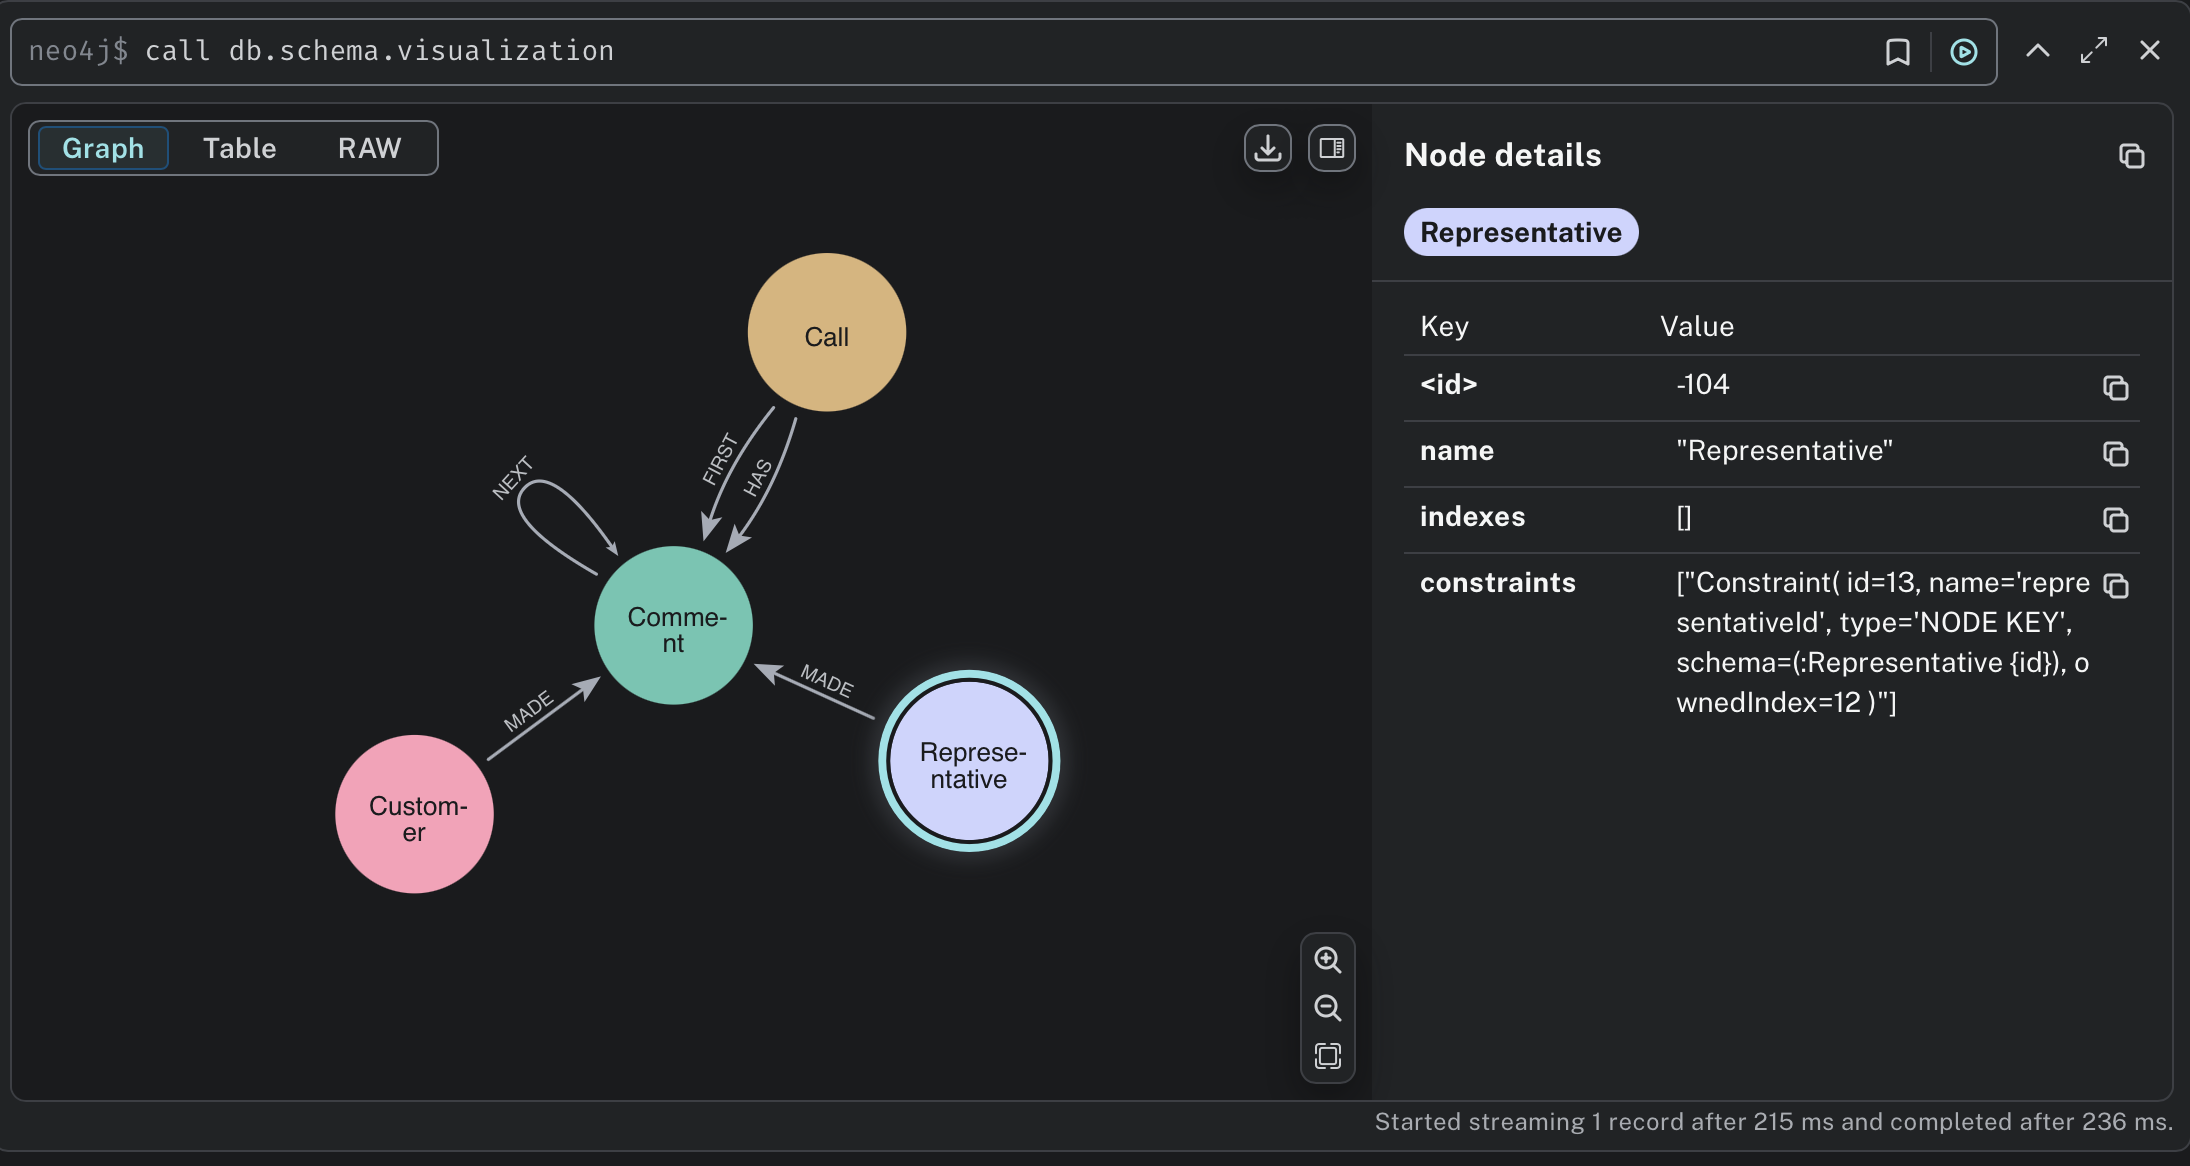